In [ ]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch

import matplotlib.pyplot as plt


In [ ]:

frame = pd.read_csv("Data/BTC-USD.csv")
frame = frame["Close"]
frame = np.asarray(frame)
frame = (frame - frame.mean())/frame.std()

series = torch.from_numpy(frame)

plt.plot(series)
plt.title("Time Series of BTC Prices")
plt.xlabel("Time in Days from T_0")
plt.ylabel("Price in USD")
plt.savefig("Bitcoin-Time-Series")
plt.show()


print(series.shape)
train_series = series[:1000]
plt.plot(train_series)
plt.show()
validation_series = series[1000:1400]
plt.plot(validation_series)
plt.show()
test_series = series[1400:]
plt.plot(test_series)
plt.show()


In [ ]:
class stockNet(nn.Module):
    
    def __init__(self, num_layers, hidden_dim):
        super().__init__()
        
        self.input_dim = 1 #The input for each time step is a scalar
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim #Dimension of the Hidden State and the Cell State
        self.lstm_layer = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        
        self.linear_layer = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        output, (hidden_state, cell_state) = self.lstm_layer(x)
        x = hidden_state[-1]
        #use a linear layer to take the last hidden output and produce a scalar value from it
        x = self.linear_layer(x)
        return x
    
class linearStockNet(nn.Module):
    def __init__(self, num_layers, num_previous_days, num_neurons):
        super().__init__()
        self.input_dim = 1
        self.layers = []
        self.layers.append(nn.Linear(num_previous_days, num_neurons))
        for _ in range(num_layers):
            self.layers.append(nn.Linear(num_neurons, num_neurons))
            self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(num_neurons, 1))
        self.net = nn.Sequential(*self.layers)
    
    def forward(self, x):
        x = x.reshape(1, 10)
        x = self.net(x)
        return x
        
    

In [ ]:
def make_batched_data(data, batch_size, previous_steps):
    ret_input = []
    ret_output = []
    n = data.shape[0]
    for i in range(previous_steps, n):
        previous_data = data[i - previous_steps:i]
        ret_input.append(previous_data)
        curr_data = data[i]
        ret_output.append(curr_data)
    
    ret_input_batched = []
    ret_output_batched = []
    index = 0
    while(index < len(ret_input)):
        data_point_input = torch.randn(batch_size, previous_steps)
        data_point_output = torch.randn(batch_size)
        offset = 0
        while(index + offset < len(ret_input) and offset < batch_size):
            data_point_input[offset] = ret_input[index + offset]
            data_point_output[offset] = ret_output[index + offset]
            offset += 1
        
        ret_input_batched.append(data_point_input)
        ret_output_batched.append(data_point_output)
        index += offset
            
    return ret_input_batched, ret_output_batched

In [25]:
def train(myNet, train_data, validation_data, batch_size, num_epochs, num_previous_days, learning_rate):


    train_inputs, train_outputs = make_batched_data(train_data, batch_size, num_previous_days)
    train_inputs = [torch.unsqueeze(T, -1) for T in train_inputs]
    train_outputs = [T.reshape(batch_size,1) for T in train_outputs]
    
    val_inputs, val_outputs = make_batched_data(validation_data, 1, num_previous_days)
    val_inputs = [torch.unsqueeze(T, -1) for T in val_inputs]
    val_outputs = [T.reshape(1,1) for T in val_outputs]
    
    criterion = nn.MSELoss()
    optimizer = optim.SGD(myNet.parameters(), lr=learning_rate, momentum=.09)
    
    training_losses = []
    validation_losses = []
    for i in range(num_epochs):
        total_loss = 0
        for j in range(len(train_inputs)):
            optimizer.zero_grad()
            pred = myNet(train_inputs[j])
            truth = train_outputs[j]
            loss = criterion(pred, truth)
            loss.backward()
            optimizer.step()
            total_loss += loss
        if(i > 0 and i%5 == 0):
            print("Average Loss for epoch " + str(i) + ": " + str(total_loss.item()/float(len(train_inputs))))
        training_losses.append(total_loss.item()/float(len(train_inputs)))
        
        val_loss = 0
        for j in range(len(val_inputs)):
            pred = myNet(val_inputs[j])
            truth = val_outputs[j]
            loss = criterion(pred, truth)
            val_loss += loss
        if(i > 0 and i%5 == 0):
            print("Average Validation loss for epoch " + str(i) + ": " + str(val_loss.item()/float(len(val_inputs))))
        validation_losses.append(val_loss.item()/float(len(val_inputs)))
    
    plt.plot(training_losses, label="Training losses")
    plt.plot(validation_losses, label="Validation losses")
    plt.title("Losses on Training and Validation as a function of Epoch")
    plt.legend()
    plt.show()
    
    return validation_losses[-1]
    
#Returns validation loss of the trained model
def do_experiment(hidden_dims, num_previous_days, num_layers, num_epochs, batch_size, learning_rate, show=False, Linear=False):    

    test_inputs, test_outputs = make_batched_data(test_series, 1, num_previous_days)
    test_inputs = [torch.unsqueeze(T, -1) for T in test_inputs]
    test_outputs = [T.reshape(1,1) for T in test_outputs]
    
    if Linear:
        myNet = linearStockNet(num_layers, num_previous_days, 32)
    else:
        myNet = stockNet(num_layers, hidden_dims)
    ret1 = train(myNet, 
          train_series, 
          validation_series, 
          batch_size=batch_size, 
          num_epochs=num_epochs, 
          num_previous_days=num_previous_days,
          learning_rate=learning_rate)
    ret2 = train(myNet, 
          validation_series, 
          train_series, 
          batch_size=batch_size, 
          num_epochs=num_epochs, 
          num_previous_days=num_previous_days,
          learning_rate=learning_rate)

    if(show):
        preds = [myNet(test_inputs[i]) for i in range(len(test_inputs))]
        criterion = nn.MSELoss()
        test_loss = 0
        for i in range(len(test_outputs)):
            test_loss += criterion(test_outputs[i], preds[i])
        print("Average MSE Loss on the test data: " + str( test_loss.item()/float(len(preds))))
        plt.title("Prediction for prices on Test Data Set with hidden Neurons = " + str(hidden_dims))
        plt.plot(preds, label="Predictions")
        plt.plot(test_outputs, label="Actual")
        plt.xlabel("Time in Days")
        plt.ylabel("Price")
        plt.savefig("HiddenDoge" + str(hidden_dims))
        plt.legend()
        plt.show()
    
    return (ret1 + ret2)/2

Average Loss for epoch 5: 0.00654745643789118
Average Validation loss for epoch 5: 2.5541737091846954
Average Loss for epoch 10: 0.006523754259552619
Average Validation loss for epoch 10: 2.4936992938701925
Average Loss for epoch 15: 0.006430569321218163
Average Validation loss for epoch 15: 2.4286693083934296
Average Loss for epoch 20: 0.006255541184935907
Average Validation loss for epoch 20: 2.351204896584535
Average Loss for epoch 25: 0.005986481603949961
Average Validation loss for epoch 25: 2.254379350711138
Average Loss for epoch 30: 0.00561472743448585
Average Validation loss for epoch 30: 2.13260748447516
Average Loss for epoch 35: 0.005142915128457426
Average Validation loss for epoch 35: 1.9836458646334134
Average Loss for epoch 40: 0.004595566277552133
Average Validation loss for epoch 40: 1.8118220402644232
Average Loss for epoch 45: 0.0040239833220086915
Average Validation loss for epoch 45: 1.6301070775741187
Average Loss for epoch 50: 0.003493294571385239
Average Valida

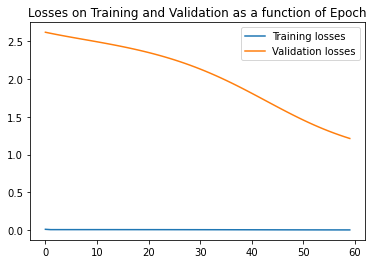

Average Loss for epoch 5: 0.03462089636386969
Average Validation loss for epoch 5: 0.004087646561439591
Average Loss for epoch 10: 0.030741000786805764
Average Validation loss for epoch 10: 0.005223831504282325
Average Loss for epoch 15: 0.027232154821738217
Average Validation loss for epoch 15: 0.0017143896131804495
Average Loss for epoch 20: 0.02428147426018348
Average Validation loss for epoch 20: 0.0044475627667976145
Average Loss for epoch 25: 0.021783432899377286
Average Validation loss for epoch 25: 0.0077934660092748775
Average Loss for epoch 30: 0.01964799715922429
Average Validation loss for epoch 30: 0.009848279664010712
Average Loss for epoch 35: 0.01782068228110289
Average Validation loss for epoch 35: 0.010667695902814769
Average Loss for epoch 40: 0.016257484753926594
Average Validation loss for epoch 40: 0.010633627573649088
Average Loss for epoch 45: 0.014920647327716533
Average Validation loss for epoch 45: 0.010044273222335661
Average Loss for epoch 50: 0.01377953474

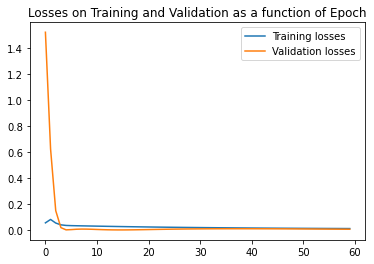

Average MSE Loss on the test data: 0.04228995186941964


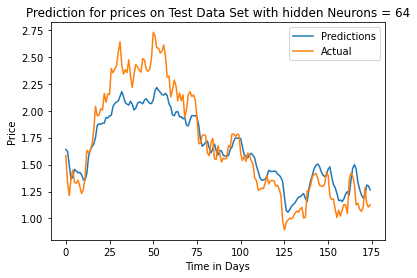

0.6102145564028155

In [26]:
do_experiment(hidden_dims=64, 
              num_previous_days=10, 
              num_layers=2, 
              num_epochs=60, 
              batch_size=10, 
              learning_rate=.15,
              show=True)

Average Loss for epoch 5: 0.006903730859660139
Average Validation loss for epoch 5: 2.672799604366987
Average Loss for epoch 10: 0.007155718827488447
Average Validation loss for epoch 10: 2.6806956755809295
Average Loss for epoch 15: 0.0073573535138910465
Average Validation loss for epoch 15: 2.6865825946514423
Average Loss for epoch 20: 0.007515117375537603
Average Validation loss for epoch 20: 2.6909993489583335
Average Loss for epoch 25: 0.007636995026559541
Average Validation loss for epoch 25: 2.6943284254807693
Average Loss for epoch 30: 0.007730783838214296
Average Validation loss for epoch 30: 2.696858410957532
Average Loss for epoch 35: 0.007803137856300431
Average Validation loss for epoch 35: 2.698794946915064
Average Loss for epoch 40: 0.00785930228955818
Average Validation loss for epoch 40: 2.7002926557491986
Average Loss for epoch 45: 0.007903252587173924
Average Validation loss for epoch 45: 2.7014576447315704
Average Loss for epoch 50: 0.007937926836688109
Average Vali

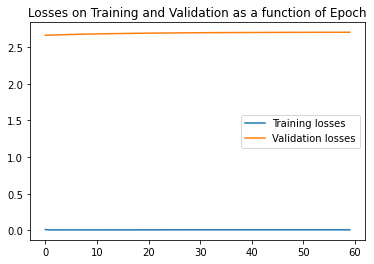

Average Loss for epoch 5: 0.36157911251752806
Average Validation loss for epoch 5: 4.381959240845959
Average Loss for epoch 10: 0.3588255124214368
Average Validation loss for epoch 10: 4.373493726325758
Average Loss for epoch 15: 0.34662963182498246
Average Validation loss for epoch 15: 4.342768998579546
Average Loss for epoch 20: 0.25177601056221205
Average Validation loss for epoch 20: 3.7592112531565656
Average Loss for epoch 25: 0.07606843801645133
Average Validation loss for epoch 25: 0.508738908864031
Average Loss for epoch 30: 0.07070714388138209
Average Validation loss for epoch 30: 0.38225701842645204
Average Loss for epoch 35: 0.0671379505059658
Average Validation loss for epoch 35: 0.4049089528093434
Average Loss for epoch 40: 0.06436848029112205
Average Validation loss for epoch 40: 0.39951150296914456
Average Loss for epoch 45: 0.05983508550203764
Average Validation loss for epoch 45: 0.37367714005287245
Average Loss for epoch 50: 0.054711341857910156
Average Validation lo

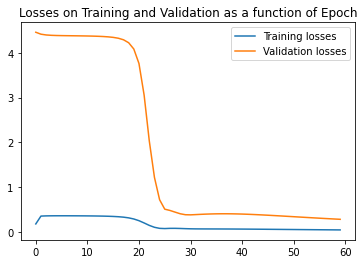

Average MSE Loss on the test data: 0.15688789367675782


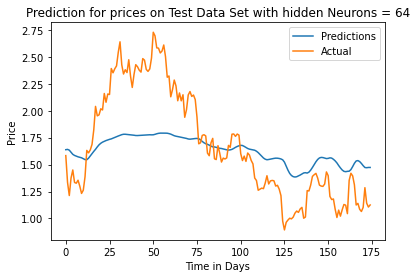

1.4931149901395262

In [27]:
do_experiment(hidden_dims=64, 
              num_previous_days=10, 
              num_layers=4, 
              num_epochs=60, 
              batch_size=10, 
              learning_rate=.15,
              show=True)

Average Loss for epoch 5: 0.006769325998094346
Average Validation loss for epoch 5: 2.6744838616786857
Average Loss for epoch 10: 0.006988788493955979
Average Validation loss for epoch 10: 2.6814634665464743
Average Loss for epoch 15: 0.007176768298100943
Average Validation loss for epoch 15: 2.6869444235777245
Average Loss for epoch 20: 0.00733563695291076
Average Validation loss for epoch 20: 2.69128668369391
Average Loss for epoch 25: 0.007468427070463547
Average Validation loss for epoch 25: 2.6947462815504806
Average Loss for epoch 30: 0.007578520461766406
Average Validation loss for epoch 30: 2.6975138346354166
Average Loss for epoch 35: 0.007669304958497635
Average Validation loss for epoch 35: 2.6997361403245193
Average Loss for epoch 40: 0.007743948637837112
Average Validation loss for epoch 40: 2.7015274439102566
Average Loss for epoch 45: 0.007805266163565896
Average Validation loss for epoch 45: 2.702977263621795
Average Loss for epoch 50: 0.007855662793824167
Average Valid

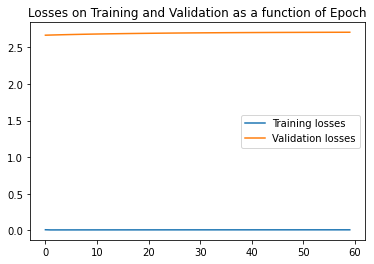

Average Loss for epoch 5: 0.3650502180441832
Average Validation loss for epoch 5: 4.386326645359849
Average Loss for epoch 10: 0.36539461673834384
Average Validation loss for epoch 10: 4.385227272727272
Average Loss for epoch 15: 0.36541415483523637
Average Validation loss for epoch 15: 4.385170553188131
Average Loss for epoch 20: 0.3654156220264924
Average Validation loss for epoch 20: 4.385167593907828
Average Loss for epoch 25: 0.3654157442924304
Average Validation loss for epoch 25: 4.385167100694445
Average Loss for epoch 30: 0.3654157442924304
Average Validation loss for epoch 30: 4.385167100694445
Average Loss for epoch 35: 0.3654157442924304
Average Validation loss for epoch 35: 4.385167100694445
Average Loss for epoch 40: 0.3654157442924304
Average Validation loss for epoch 40: 4.385167100694445
Average Loss for epoch 45: 0.3654157442924304
Average Validation loss for epoch 45: 4.385167100694445
Average Loss for epoch 50: 0.3654157442924304
Average Validation loss for epoch 50

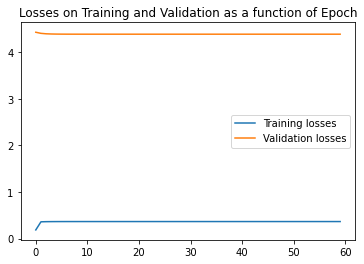

Average MSE Loss on the test data: 0.2956294686453683


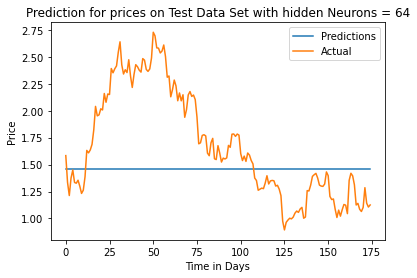

3.5454620622162127

In [28]:
do_experiment(hidden_dims=64, 
              num_previous_days=10, 
              num_layers=1, 
              num_epochs=60, 
              batch_size=10, 
              learning_rate=.15,
              show=True)